# Mount Google Drive to Colab Environment
This code is used to mount your Google Drive account to the Colab environment, allowing you to access the files stored in your Google Drive directly from Colab. 

The `drive.mount()` function creates a connection between Colab and your Google Drive account and mounts your Google Drive at the specified location (in this case, `/content/drive`).



In [1]:
# Importing the 'drive' module from the 'google.colab' package
from google.colab import drive

# Mounting Google Drive to the '/content/drive' directory in the Colab environment
drive.mount('/content/drive')

Mounted at /content/drive


# Installing Required Packages

This code is used to install various required packages in the environment. 

The `!pip install` command is used to install the packages, and the `-U` flag is used to upgrade an already installed package to a specific version. 

In this case, the packages being installed are `preprocess`, `mxnet-cu101`, `d2l`, `h5py`, and `pyyaml`.

In [ ]:
# Installing Required Packages

# Installing the 'preprocess' package
!pip install preprocess

# Updating the 'mxnet-cu101' package to version 1.7.0
!pip install -U mxnet-cu101==1.7.0

# Installing the 'd2l' package version 1.0.0-alpha0
!pip install d2l==1.0.0-alpha0

# Installing the 'h5py' and 'pyyaml' packages
!pip install h5py pyyaml

# Setting up a Deep Learning Environment in TensorFlow

This code is used to set up a deep learning environment in TensorFlow. 

The `%load_ext tensorboard` line is used to load the TensorBoard extension for Jupyter Notebook. The code then imports the required libraries, including `os`, `numpy`, `pandas`, `matplotlib`, `preprocess`, and `cv2`. 

Additionally, it imports various TensorFlow libraries, including `keras`, `models`, `layers`, `optimizers`, and `preprocessing`, which are used to build, compile, and train deep learning models. 

Finally, it imports the Python Imaging Library (PIL) to work with images.


In [3]:
# Loading TensorBoard Extension
%load_ext tensorboard

# Importing Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import preprocess as pp
import cv2

# Importing TensorFlow Libraries
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Importing PIL Library
import PIL.Image


# Setting GPU Configuration in TensorFlow

In [4]:
import tensorflow as tf

#Used to get the list of physical GPUs available in the environment. 
#The `len(physical_devices)` line is used to get the number of GPUs available and `print` it.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

#Used to set the memory growth of the first GPU (at index 0) to True, 
# allowing TensorFlow to dynamically allocate memory as required by the model during training. 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


# Import the labeled dataset from  NASA’s LAADS DAAC archives. 

Fast Fourier Transform has been applied to the images in the dataset for denoising.

In [5]:
# Setting the Working Directory in Python

data_path = ('/content/drive/MyDrive/fft-denoised/')
os.chdir(data_path)
print(os.path.abspath(os.getcwd()))

/content/drive/MyDrive/fft-denoised


# Loading the pre-trained model Inception V3, which was trained with imagenet dataset.

All layers in the Inception V3 has been assigned to be non-trainable.


In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf

from keras import regularizers
from keras.models import Model

base_model = InceptionV3(input_shape = (256,256,3), include_top = False, weights = 'imagenet')

# Freeze all the layers
for layer in base_model.layers:
  layer.trainable = False

# Check the trainable status of the individual layers

#for layer in base_model.layers:
  #print(layer, layer.trainable)

#base_model.summary()

87910968/87910968 [==============================] - 1s 0us/step


# Extracting the last layer of the InceptionV3 model. 

This code can be used as a feature extractor for transfer learning, where the last layer of the pre-trained model is used as input for a new, custom model.

The reason for that is because for the Inception Model V3, the largest feature map is produced by this layer, and further layers have lower dimensions. So for the purpose of feature extraction, we want to use the feature map with the most dimensions possible.

In [7]:
#The last_layer variable is assigned the value of the 'mixed7' layer of the base_model.
last_layer = base_model.get_layer('mixed7')

#The output shape of the last layer is then printed, and the last_output variable is assigned the value of the output of the last layer.
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 768)


# Applying  L1 and L2 regularization to all Conv2D layers in the base_model.

The if statement is checking for each layer in the base_model if it is a Conv2D layer. If it is, it adds L1 and L2 regularization to that layer using the kernel_regularizer attribute and the l1 and l2 functions from the keras.regularizers module, with a regularization factor of 0.0001 for both L1 and L2. Regularization helps to prevent overfitting in the model.

In [8]:
#Adding L1 and L2 regularization to the Conv2D layers in the base_model.
for layer in base_model.layers:
  if layer.__class__.__name__ == 'Conv2D':
    layer.kernel_regularizer = keras.regularizers.l1(0.0001)
    layer.kernel_regularizer = keras.regularizers.l2(0.0001)

# Defining Custom Model with trainable layers

Defining a function model_call() which returns a deep learning model that can be used for binary classification tasks. 

The function uses the Model class from the TensorFlow library to create a model that takes the pre-trained InceptionV3 model as its base and adds a custom top layer for classification.

In [9]:
# Import required libraries
from tensorflow.keras import activations
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.layers import Conv2D, Convolution2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# Define the model_call function
def model_call():

  # Flatten the output from the mixed7 layer of the base model
  x = layers.Flatten()(last_output) #mixed 7

  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)

  # Add dropout regularization to the fully connected layer
  x = layers.Dropout(0.3)(x)      

  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)         

  # Create the model by using the base model as input and the sigmoid layer as output
  model = Model(base_model.input, x)

  # Compile the model using the Adam optimizer, binary crossentropy loss, and accuracy metrics
  model.compile(optimizer = Adam(lr=1e-04),
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])
                
  # Return the compiled model
  return model

# Displaying a Summary of the custom model on top of the pre-trained model

The summary includes information about the layers in the model, the shapes of their outputs, the number of parameters in each layer, and the total number of parameters in the model. This is a useful tool for understanding the structure and complexity of the model, and for identifying any potential issues or problems with the architecture.

In [11]:
model = model_call()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

#  Custom callback class myCallback.

The class is used to monitor the accuracy of a model during training and print out messages based on the accuracy values achieved. The class implements the on_epoch_end method which is called at the end of each epoch during model training.

The method checks the accuracy value stored in the logs dictionary at the end of each epoch and based on the accuracy value, it prints out various messages. If the accuracy reaches 99%, the training will stop as the message "Reached 99% accuracy so cancelling training!" is printed. If the validation accuracy reaches 95% or more, the training will stop with the message "Reached 95% or more validation accuracy, training finished.". The code also prints messages if the validation accuracy reaches 93% and 90%.

In [13]:
# Defining a callback to monitor the accuracy during training
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    # Check if validation accuracy is greater than or equal to 95%, to make early stop
    if(logs.get('val_accuracy')>0.9499):
      print("\nReached 95% or more validation accuracy, training finished.")
      self.model.stop_training = True

    # Check if validation accuracy is greater than or equal to 93%
    elif(logs.get('val_accuracy')>0.93):
      print(f"\nReached 93% validation accuracy mark!!!")
      
    # Check if validation accuracy is greater than or equal to 90%
    elif(logs.get('val_accuracy')>0.8999):
      print(f"\nReached 90% validation accuracy mark!")

# Initializing the callback object
accstop = myCallback()

# Defining parameters to create image data generators for training, validation, and testing datasets.

The train_datagen generator is defined using the ImageDataGenerator class from TensorFlow's Keras library. This generator will be used to augment the training data.

The test_datagen generator is then defined using the same ImageDataGenerator class, but only with the rescale parameter set to normalize the pixel values.

Next, the training generator is defined using the train_datagen generator.

Training data is then extracted from the generator and stored in a list. This list is then converted to a numpy array, which is stored in the train_array variable.

Similarly, the validation generator is defined using the train_datagen generator, with the directory set to ./validation. The validation data is then extracted from the generator and stored in a numpy array, which is stored in the validation_array variable.

Finally, the testing generator is defined using the test_datagen generator, with the directory set to ./test. The testing data is then extracted from the generator and stored in a numpy array, which is stored in the test_array variable.



In [14]:
# Define the batch size for training and testing
batch_size = 35

# Create ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(
        width_shift_range = 0.2, # randomly shift images horizontally
        rescale=1/255,           # normalize pixel values
        shear_range=0.2,         # apply random shear transformation
        horizontal_flip=True,    # randomly flip images horizontally
        )

# Create ImageDataGenerator for test data without data augmentation
test_datagen = ImageDataGenerator(
        rescale=1/255)           # normalize pixel values

# Create a generator for the training data and retrieve all images
train_generator = train_datagen.flow_from_directory(
        './train',               # path to the training data directory
        target_size=(256, 256),  # target image size
        batch_size= batch_size,  # batch size defined above
        shuffle = True,          # shuffle the images
        class_mode='binary')     # binary classification problem

# Create a list to store all the training images
train_list = []
batch_index = 0
while batch_index <= train_generator.batch_index:
  train = train_generator.next()
  train_list.append(train[0])    # append the images to the list
  batch_index = batch_index + 1

# Convert the list of images to a numpy array
train_array = np.asarray(train_list)

# Create a generator for the validation data and retrieve all images
validation_generator = train_datagen.flow_from_directory(
        './validation',          # path to the validation data directory
        target_size=(256, 256),  # target image size
        batch_size= 35,          # batch size defined as 35
        class_mode='binary')     # binary classification problem

# Create a list to store all the validation images
validation_list = []
batch_index = 0
while batch_index <= validation_generator.batch_index:
  validation = validation_generator.next()
  validation_list.append(validation[0])    # append the images to the list
  batch_index = batch_index + 1

# Convert the list of images to a numpy array
validation_array = np.asarray(validation_list)

# Create a generator for the test data and retrieve all images
test_generator = test_datagen.flow_from_directory(
        './test',                # path to the test data directory
        target_size=(256, 256),  # target image size
        batch_size= batch_size,  # batch size defined above
        class_mode= 'binary')    # binary classification problem

# Create a list to store all the test images
test_list = []
batch_index = 0
while batch_index <= test_generator.batch_index:
  test = test_generator.next()
  test_list.append(test[0])      # append the images to the list
  batch_index = batch_index + 1 

# Convert the list of images to a numpy array
test_array = np.asarray(test_list)

Found 306 images belonging to 2 classes.


<ipython-input-14-2d420bdcf6ea>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_array = np.asarray(train_list)


Found 58 images belonging to 2 classes.


<ipython-input-14-2d420bdcf6ea>:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  validation_array = np.asarray(validation_list)


Found 219 images belonging to 2 classes.


<ipython-input-14-2d420bdcf6ea>:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_array = np.asarray(test_list)


# Displaying Images after Data Augmentation

The code uses the Matplotlib library to generate and display 9 subplots.



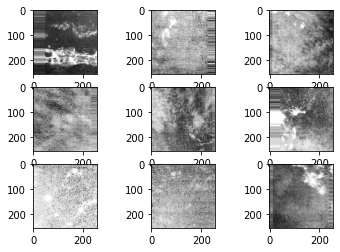

In [ ]:
# This code generates and displays 9 subplots using the Matplotlib library

for i in range(9):
    # This creates a subplot with a 3x3 grid, with the current subplot being located at (3, 3, i+1)
    plt.subplot(330 + 1 + i) 
    
    # This retrieves the next set of images and labels from the training generator
    images, labels = train_generator.next() 
    
    # This rescales the image from 0-1 to 0-255 and converts it to an 8-bit unsigned integer
    image = (images[0]*255).astype('uint8') 
    
    # This displays the image on the current subplot
    plt.imshow(image) 


# Defining a neural network model by calling a function named model_call(). 

After the model is defined, the code plots a graphical representation of the model using the plot_model() function from the keras.utils module. 

The plot_model() function takes the model as an argument and plots the architecture of the model. 

The to_file argument is used to specify the name and location of the file where the plot will be saved. 

The show_shapes argument is set to True to indicate that the shapes of the model inputs and outputs should be displayed on the plot. The show_layer_names argument is set to True to indicate that the names of the model layers should be displayed on the plot.

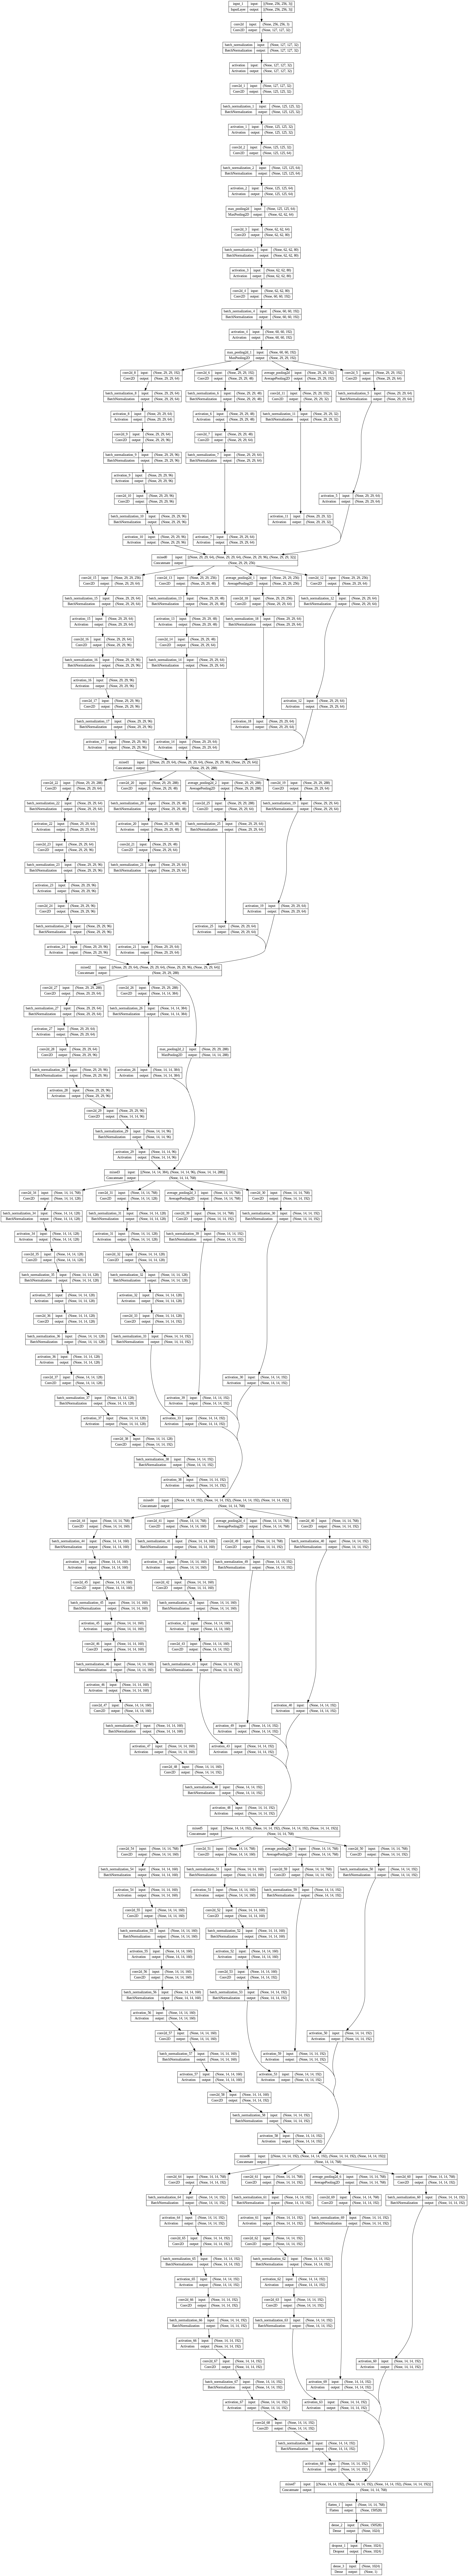

In [15]:
# Initialize the model
model1 = model_call()

# Plot the model architecture
# 'model_plot.png' is the file name to save the plot
# 'show_shapes' argument is set to True to show the shapes of the layers in the plot
# 'show_layer_names' argument is set to True to show the names of the layers in the plot
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True) 

# Training the Custom Model 

1. Imports the callbacks module from TensorFlow's Keras library.

2. Initializes two lists, test_acc_per_fold and test_loss_per_fold to store the accuracy and loss per fold for testing.

3. Initialized the Learning Rate Scheduler to lower learning rate of training if there is no improvement in the accuracy or loss values.

4. Calls the model_call() function to create the model.

5. Sets the number of epochs to 300.

6. Fits the model on the training data using the train_generator generator, with 3 steps per epoch, 300 epochs, validation data from validation_generator, and the accstop callback. The number of validation steps is set to 1.

7. Evaluates the model on the training data using train_generator.

8. Evaluates the model on the validation data using validation_generator.

9. Evaluates the model on the test data using test_generator.

10. Finds the best accuracy, loss, validation accuracy, and validation loss from the history of the model training.

In [ ]:
# Import the callbacks module from TensorFlow's Keras library
from tensorflow.keras import callbacks

# Initialize the ReduceLROnPlateau callback
# This callback is used to reduce the learning rate of the model when the validation loss has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    # The quantity to be monitored
    monitor='val_loss', 
    # The factor by which the learning rate will be reduced
    factor=0.1, 
    # The number of epochs with no improvement after which the learning rate will be reduced
    patience=20, 
    # The minimum value the learning rate can be reduced to
    min_lr=1e-13
)

# Call the model_call() function to create the model
model = model_call()
epoch = 300                 # Set the number of epochs to 300

# Fit the model on the training data
kh = model.fit(        
        train_generator,                       # Pass the training generator
        steps_per_epoch= 3,          # Set the number of steps per epoch to 3
        epochs = epoch,                     # Set the number of epochs to 300
        validation_data=validation_generator,  # Pass the validation generator
        callbacks = [accstop],                 # Pass the accstop callback
        validation_steps= 1          # Set the number of validation steps to 1
        )
# Evaluate the model on the training data
scores = model.evaluate(train_generator, verbose=0)

# Evaluate the model on the validation data
results = model.evaluate(validation_generator, verbose = 0)

# Evaluate the model on the test data
test_results = model.evaluate(test_generator, verbose = 0)

# Find the best accuracy, loss, validation accuracy, and validation loss from the history of the model training
best_acc = max(kh.history['accuracy']); best_loss = min(kh.history['loss']); best_val_acc = max(kh.history['val_accuracy']); best_val_loss = min(kh.history['val_loss'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/300
3/3 [==============================] - 9s 3s/step - loss: 1.4829 - accuracy: 0.4321 - val_loss: 0.9778 - val_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 2/300
3/3 [==============================] - 4s 2s/step - loss: 0.7962 - accuracy: 0.4938 - val_loss: 0.6417 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 3/300
3/3 [==============================] - 4s 2s/step - loss: 0.6194 - accuracy: 0.6129 - val_loss: 0.6342 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 4/300
3/3 [==============================] - 4s 2s/step - loss: 0.6841 - accuracy: 0.5645 - val_loss: 0.5899 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 5/300
3/3 [==============================] - 4s 2s/step - loss: 0.6182 - accuracy: 0.6049 - val_loss: 0.4668 - val_accuracy: 0.8500 - lr: 1.0000e-04
Epoch 6/300
3/3 [==============================] - 5s 2s/step - loss: 0.6428 - accuracy: 0.6296 - val_loss: 0.5185 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 7/300
3/3 [==============================] - 5s 2s/step - loss: 

# Training Analysis

Prints a summary of the results of training the custom model.

The summary includes training and validation scores, as well as the best accuracy and loss values.

The final section of the summary prints the highest accuracy and lowest loss achieved during the training process.

In [ ]:
print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------')

# Print the training score with the first metric name and value and the second metric name and value
print(f'Training Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%;  \n' )

# Print the validation score with the first metric name and value and the second metric name and value
print(f'Validation Score validation {model.metrics_names[0]} of {results[0]}; validation {model.metrics_names[1]} of {results[1]*100}%;  \n' )

# Print the test score with the first metric name and value and the second metric name and value
print(f'Test Score validation {model.metrics_names[0]} of {results[0]}; test {model.metrics_names[1]} of {results[1]*100}%;  \n' )

# Print the best accuracy, loss, validation accuracy, and validation loss
print(f' Best Accuracy: {best_acc*100}%;  Best Loss: {best_loss}; Best Val_Accuracy: {best_val_acc*100}%; Best Val_Loss: {best_val_loss} \n' )

print('-----------------------------------------------------------------------------------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------------------------------------------------------------------------------
Training Score : loss of 0.2801409363746643; accuracy of 89.99999761581421%;  

Validation Score: loss of 0.5361030101776123; validation accuracy of 74.28571581840515%;  

Test Score: test loss of 0.5719607472419739; test accuracy of 75.8474588394165%;  

 Best Accuracy: 96.77419066429138%;  Best Loss: 0.18052047491073608; Best Val_Accuracy: 94.9999988079071%; Best Val_Loss: 0.2298315018415451 

-----------------------------------------------------------------------------------------------------------------------------------------------------------------


# Setting the Plot

Creating a line plot to visualize the training and validation accuracy over the number of epochs. 
The kh.history object is a dictionary that stores the accuracy values at each epoch during training and validation. 
The plt.plot() function is used to plot the values in kh.history['accuracy'] and kh.history['val_accuracy'] on the same graph.

The plt.ylabel() function is used to set the y-axis label to "Accuracy". This label indicates that the y-axis represents accuracy values. The plt.xlabel() function is used to set the x-axis label to "Epoch". This label indicates that the x-axis represents the number of epochs.

Finally, the plt.show() function is used to display the plot. This makes it possible to see the results of the code and understand how the accuracy changed over the number of epochs.

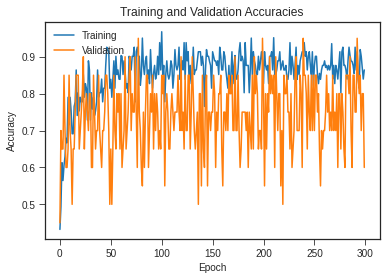

In [ ]:
# Plot the training and validation accuracy
plt.plot(kh.history['accuracy'])
plt.plot(kh.history['val_accuracy'])

# Set the title of the plot
plt.title('Training and Validation Accuracies')

# Set the y-axis label to "Accuracy"
plt.ylabel('Accuracy')

# Set the x-axis label to "Epoch"
plt.xlabel('Epoch')

# Add a legend to the plot, with "Training" and "Validation" as the labels, and the location set to "upper left"
plt.legend(['Training', 'Validation'], loc = 'upper left')

# Show the plot
plt.show()


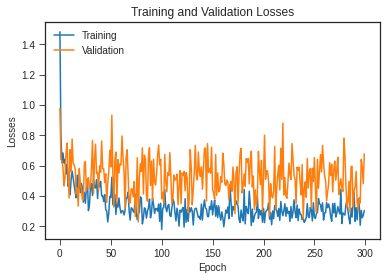

In [ ]:
# Plot the training and validation loss
plt.plot(kh.history['loss'])
plt.plot(kh.history['val_loss'])

# Set the title of the plot
plt.title('Training and Validation Losses')

# Set the y-axis label to "Loss"
plt.ylabel('Loss')

# Set the x-axis label to "Epoch"
plt.xlabel('Epoch')

# Add a legend to the plot, with "Training" and "Validation" as the labels, and the location set to "upper left"
plt.legend(['Training', 'Validation'], loc = 'upper left')

# Show the plot
plt.show()


# Evaluating accuracy of the test set

Evaluates the performance of the custom model on a test set using the 
model.evaluate() function. This function calculates the accuracy of the model on the test set, which is a measure of how well the model is able to predict the correct labels.

 The accuracy is printed to the console using the print() function. This makes it possible to see the accuracy of the model on the test set and understand how well it is performing.

In [ ]:
# Evaluate the model on the test set
_, acc = model.evaluate(test_generator)

# Print the accuracy on the test set
print(acc)

9/9 [==============================] - 5s 518ms/step - loss: 0.5720 - accuracy: 0.7585
0.758474588394165


# Evaluating accuracy of the validation set

 Evaluates the performance of the custom model on a validation set using the 
 model.evaluate() function. This function calculates the accuracy of the model on the validation set, which is a measure of how well the model is able to predict the correct labels on a dataset it has not seen before.

 The accuracy is printed to the console using the print() function. This makes it possible to see the accuracy of the model on the validation set and understand how well it is performing, especially compared to its performance on the training set.

In [ ]:
# Evaluate the model on the validation set
_, acc = model.evaluate(validation_generator)

# Print the accuracy on the validation set
print(acc)

7/7 [==============================] - 5s 647ms/step - loss: 0.5250 - accuracy: 0.7571
0.7571428418159485


# Calculating Precision, Recall and F1 Score on the validation set

These metrics can be used to monitor the training process, to evaluate the performance of the custom model on a validation set.

In [ ]:
# Importing Precision and Recall from the tensorflow.keras.metrics module
from tensorflow.keras.metrics import Precision, Recall

# Instantiating objects of the Precision and Recall classes
pre = Precision()
re = Recall()

# Loop over the validation data
for batch in validation:
  # Get the inputs and target values from the batch
  X, y = validation
  # Predict the output using the model
  yhat = model.predict(X)
  # Update the state of the Precision and Recall objects with the batch results
  pre.update_state(y, yhat)
  re.update_state(y, yhat)

# Calculate the F1 score as the harmonic mean of precision and recall
f1_score = (2 * pre.result().numpy() * re.result()) / (pre.result().numpy() + re.result())

# Print the precision, recall, and F1 score for the validation data
print('For Validation: ')
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, F1 Score: {f1_score}')


For Validation: 
Precision: 0.6666666865348816, Recall: 0.800000011920929, Accuracy: 0.699999988079071, F1 Score: 0.7272727489471436


# Calculating Precision, Recall and F1 Score on the test set

These metrics can be used to monitor the training process, to evaluate the performance of the custom model on a test set.

In [ ]:
# Importing Precision and Recall from the tensorflow.keras.metrics module
from tensorflow.keras.metrics import Precision, Recall

# Instantiating objects of the Precision and Recall classes
pre = Precision()
re = Recall()

# Loop over the test data
for batch in test:
  # Get the inputs and target values from the batch
  X, y = test
  # Predict the output using the model
  yhat = model.predict(X)
  # Update the state of the Precision and Recall objects with the batch results
  pre.update_state(y, yhat)
  re.update_state(y, yhat)

# Calculate the F1 score as the harmonic mean of precision and recall
f1_score = (2 * pre.result().numpy() * re.result()) / (pre.result().numpy() + re.result())

# Print the precision, recall, and F1 score for the test data
print('For Test: ')
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, F1 Score: {f1_score}')


For Test: 
Precision: 0.6666666865348816, Recall: 1.0, Accuracy: 0.800000011920929, F1 Score: 0.800000011920929


# Predictions on Validation and Test dataset

1. The pred variable is assigned the result of making predictions on the validation dataset using the model.predict() method.

2. The test_pred variable is assigned the result of making predictions on the test dataset using the model.predict() method.

3. The function countpredictions() takes two arguments: predictions and gw, ngw, where gw and ngw are the count of positive and negative predictions, respectively.
    - For each prediction in predictions, the code checks if the prediction value is greater than 0.5. If it is, ngw is incremented, otherwise, gw is incremented.

    - Finally, the function returns the count of positive and negative predictions.

4. The countpredictions() function is called with pred as an argument and the result is printed.

5. Similarly, the countpredictions() function is called with test_pred as an argument and the result is printed.

In [ ]:
# Make predictions on validation and test datasets
pred = model.predict(validation_generator)
test_pred = model.predict(test_generator)

# Print header for validation predictions
print("Validation Predictions:\n")

# Define a function to count positive and negative predictions
def countpredictions(predictions, gw = 0, ngw = 0):
  for pred in predictions:
    # If prediction value is greater than 0.5, increment ngw (negative predictions)
    if pred > 0.5:
      ngw += 1
    # If prediction value is less than or equal to 0.5, increment gw (positive predictions)
    else:
      gw += 1
  # Return the count of positive and negative predictions
  return gw, ngw

# Call the countpredictions function on validation predictions and print the results
print(countpredictions(pred, 0, 0))

# Print header for test predictions
print("\nTest Predictions:\n")

# Call the countpredictions function on test predictions and print the results
print(countpredictions(test_pred, 0, 0))


validation predictions:

(72, 68)

test predictions:

(112, 124)


# Calculating Confusion Matrix

The predictions made by the model are rounded and stored in the pred variable. 

The confusion_matrix is calculated by calling metrics.confusion_matrix with y_true set to the true classes and y_pred set to the rounded predictions. 

The resulting confusion matrix has the following components:

    - True Positives (TP): The number of instances that are true and are predicted to be true.
    - False Negatives (FN): The number of instances that are true but are predicted to be false.
    - False Positives (FP): The number of instances that are false but are predicted to be true.
    - True Negatives (TN): The number of instances that are false and are predicted to be false.




In [ ]:
import sklearn.metrics as metrics

# Print the confusion matrix
print("Confusion Matrix: \n")

# Get the true classes from the validation generator
true_classes = validation_generator.classes

# Get the class labels from the validation generator
class_labels = list(validation_generator.class_indices.keys())

# Round the predictions to get binary values
pred = np.round(pred)

# Create the confusion matrix using true classes and the rounded predictions
confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=pred)

# Print the confusion matrix
confusion_matrix

Confusion Matrix: 



array([[41, 29],
       [31, 39]])

# Plotting the Learning Rate Scheduler 

Uses the matplotlib library to plot the learning rate against the number of epochs during training of a machine learning model.

The number of epochs and the learning rate are obtained from the history of the fit function. A range of x values for the plot is created and a new figure is initialized with a specified size.

The learning rate is then plotted against the number of epochs by calling the plot function from the pyplot library. Labels are added to the x-axis and y-axis, and a title is added to the plot. The grid for the plot is turned on, and the seaborn-ticks style is applied to the plot.

This code provides a visual representation of the learning rate, which can be useful in understanding how the model is learning over time, and in determining if the learning rate is well-suited for the training process.

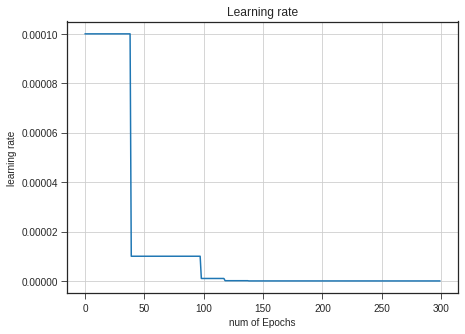

In [ ]:
# Import the matplotlib library
import matplotlib.pyplot as plt

# Get the number of epochs from the history of the fit function
nb_epoch = len(kh.history['loss'])

# Get the learning rate from the history of the fit function
learning_rate = kh.history['lr']

# Create a range of x values for the plot
xc = range(nb_epoch)

# Initialize a figure
plt.figure(3, figsize=(7, 5))

# Plot the learning rate against the number of epochs
plt.plot(xc, learning_rate)

# Add labels to the x-axis and y-axis
plt.xlabel('Number of Epochs')
plt.ylabel('Learning rate')

# Add a title to the plot
plt.title('Learning rate')

# Turn on the grid for the plot
plt.grid(True)

# Use the seaborn-ticks style for the plot
plt.style.use(['seaborn-ticks'])
